In [1]:
if 'google.colab' in str(get_ipython()):
    !pip install git+https://github.com/ourownstory/neural_prophet.git # may take a while
    #!pip install neuralprophet # much faster, but may not have the latest upgrades/bugfixes
    data_location = "https://raw.githubusercontent.com/ourownstory/neural_prophet/master/"
else:
    data_location = "../"

In [2]:
from collections import namedtuple
import pandas as pd
import matplotlib.pyplot as plt
from neuralprophet import NeuralProphet, set_log_level
set_log_level("ERROR")

In [3]:
Experiment = namedtuple('Experiment', ['data', 'freq', 'model_config'])
experiments = [
    Experiment(
        data="air_passengers.csv",
        freq="MS",
        model_config={"seasonality_mode":"multiplicative"},
    ),
    Experiment(
        data="wp_log_peyton_manning.csv",
        freq="D",
        model_config={"n_changepoints": 50},
    ),
    Experiment(
        data="yosemite_temps.csv",
        freq="5min",
        model_config={"n_forecasts": 12, "n_lags": 36},
    ),
]

In [4]:
def run_experiment(e, plot=False):
    df = pd.read_csv(data_location + "example_data/" + e.data)
    print(" ---- running exp: {} (len: {}) ----".format(e.data, len(df)))
    folds = NeuralProphet(**e.model_config).crossvalidation_split_df(df, freq=e.freq, k=5, fold_pct=0.1, fold_overlap_pct=0.0)
    train, val = [], []
    for df_train, df_val in folds:
        m = NeuralProphet(**e.model_config)
        metrics_train = m.fit(df_train, freq=e.freq)
        metrics_val = m.test(df_val)
        train.append(metrics_train["MAE"].values[-1])
        val.append(metrics_val["MAE"].values[-1])
    if plot:
        future = m.make_future_dataframe(df_train, periods=len(df_val), n_historic_predictions=len(df_train))
        forecast = m.predict(future)
        fig = m.plot(forecast)
        plt.show()
    print("train MAE:", train)
    print("train MAE:", val)
    print("train MAE (avg):", sum(train)/len(train))
    print("train MAE (avg):", sum(val)/len(val))
    

 ---- running exp: air_passengers.csv (len: 144) ----


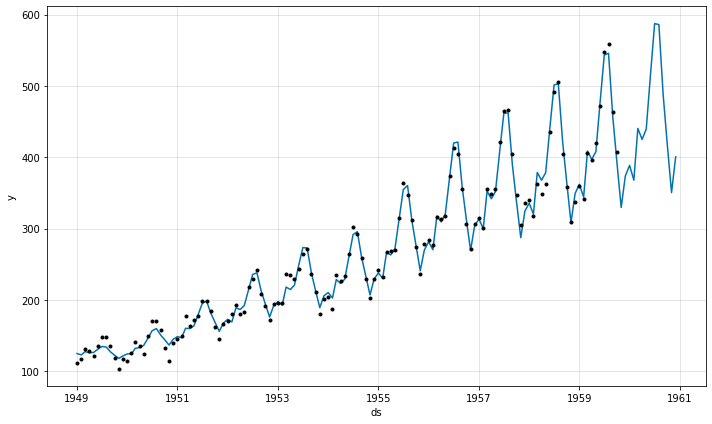

train MAE: [4.763150485786232, 5.516819780523127, 5.141293329351089, 6.117330485376819, 6.480967294252836]
train MAE: [10.33949089050293, 12.415788650512695, 16.647327423095703, 12.958258628845215, 29.398988723754883]
train MAE (avg): 5.60391227505802
train MAE (avg): 16.351970863342284
 ---- running exp: wp_log_peyton_manning.csv (len: 2905) ----


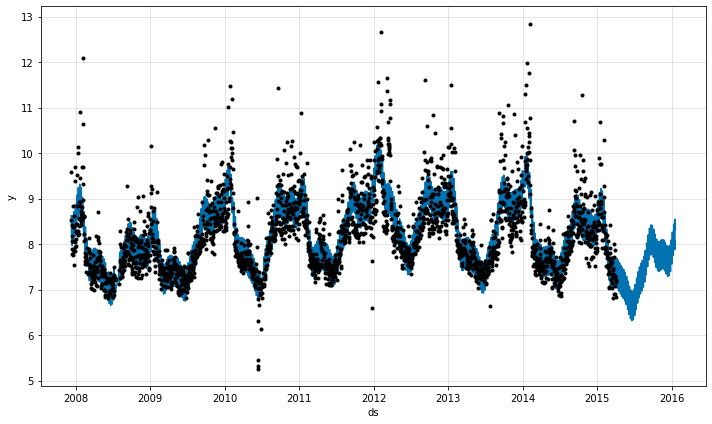

train MAE: [0.28714315255278167, 0.31116829982459715, 0.3108819184271065, 0.32840600319447055, 0.32619354910649945]
train MAE: [0.4645514190196991, 0.41877156496047974, 0.6513427495956421, 0.32039323449134827, 0.35639259219169617]
train MAE (avg): 0.312758584621091
train MAE (avg): 0.44229031205177305
 ---- running exp: yosemite_temps.csv (len: 18721) ----


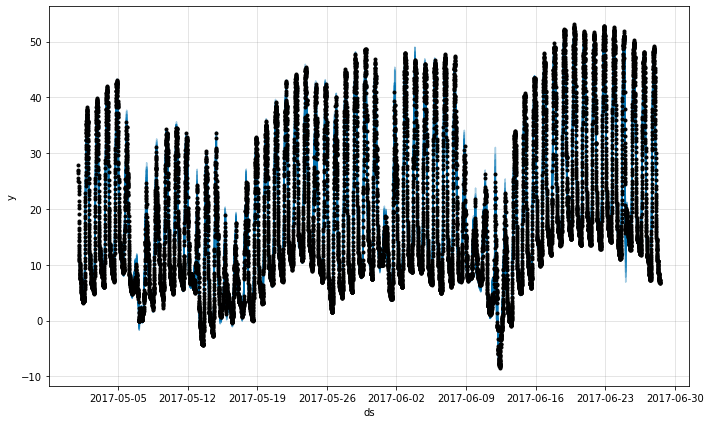

train MAE: [0.9814785349142969, 0.9576072608565569, 0.9866412852990231, 0.9363895984497899, 0.9060823086855659]
train MAE: [1.9519328703067693, 1.4564445311361316, 1.6349658233943092, 1.677412820398999, 0.6534090793401098]
train MAE (avg): 0.9536397976410464
train MAE (avg): 1.4748330249152637


In [5]:
for exp in experiments:
    run_experiment(exp, plot=True)